In [1]:
import torch
import numpy as np
import timeit
import matplotlib.pyplot as plt
import math
import copy
torch.manual_seed(8)

C:\Users\User\Anaconda3\envs\py39torch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# UTILS

In [2]:
def creat_random_initial_matrix(m_size,n_size,tight_frame = False):
    
    init_mat = torch.normal(mean = 0, std = 1 , size=(m_size,n_size))
    init_mat = make_unit_matrix(init_mat)
    if tight_frame :
        init_mat = create_tight_frame(init_mat)
    return init_mat

def create_tight_frame(matrix):
    U, _ , Vh = torch.linalg.svd(matrix, full_matrices=False)
    matrix = torch.mm(U , Vh)
    return make_unit_matrix(matrix)

def make_unit_matrix(matrix):
    norm2 = torch.norm(matrix, dim = 0 , keepdim=True)
    return matrix / norm2




def calculate_GI_and_MU_and_MU_mean(matrix):
    G_i = torch.abs(torch.mm(torch.transpose(matrix, 0, 1), matrix) - torch.eye(matrix.shape[-1]))
    return G_i, torch.max(G_i).detach(), (torch.sum(G_i)/(G_i.shape[0]*(G_i.shape[0]-1))).detach()

def calculate_Spectral_norm(matrix):
    return torch.max(torch.linalg.svdvals(matrix)).detach()




def plot_histogram(matrix , bins_ = 20 , max_hist = 0):
    G_i,_,_ = calculate_GI_and_MU_and_MU_mean(matrix)
    hist_G_i = torch.zeros(G_i.shape[0]*(G_i.shape[0]-1))
    k = 0
    for i in range(G_i.shape[0]):
        l = len(G_i[i,i+1:])
        hist_G_i[k:k+l] = G_i[i,i+1:]
        k = k+l
    hist_G_i[k:] = hist_G_i[0:k]
    hist_G_i = hist_G_i.numpy()
    if max_hist != 0:
        hist_G_i_bins = np.arange(bins_+5) / bins_ * max_hist
    else :
        hist_G_i_bins = bins_
    
    plt.figure(figsize = (10,5))
    plt.title("Histogram of G_i with off-diagonal")
    plt.hist( hist_G_i ,hist_G_i_bins )


def SLEAp_loss(G_i, p= 1e2 ,max_=0):
    return torch.log( torch.sum( torch.exp( p * (G_i-max_))))/p



# For manual calculating gradient
def LSEAp_grad(matrix , p):
    GI = calculate_GI(matrix)
    max_ = torch.max(abs(GI))
    sig_ = torch.sgn(GI)
    exp_ = torch.exp(p*(abs(GI)-max_))
    return sig_ * exp_ / torch.sum(exp_)

# For manual calculating gradient
def linf_grad(matrix,p):
    grad = torch.zeros_like(matrix)
    grad_g = LSEAp_grad(matrix,p)
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            grad_u = torch.zeros((matrix.shape[1],matrix.shape[1]))
            grad_u[j,:] = matrix[i,:]
            grad_u = grad_u + torch.transpose(grad_u, 0, 1)
            grad[i,j] = torch.trace(torch.mm(grad_g, grad_u))   
    return grad


def plot_histogram(matrix , bins_ = 20 , max_hist = 0):
    G_i,_,_ = calculate_GI_and_MU_and_MU_mean(matrix)
    hist_G_i = torch.zeros(G_i.shape[0]*(G_i.shape[0]-1))
    k = 0
    for i in range(G_i.shape[0]):
        l = len(G_i[i,i+1:])
        hist_G_i[k:k+l] = G_i[i,i+1:]
        k = k+l
    hist_G_i[k:] = hist_G_i[0:k]
    hist_G_i = hist_G_i.numpy()
    if max_hist != 0:
        hist_G_i_bins = np.arange(bins_+5) / bins_ * max_hist
    else :
        hist_G_i_bins = bins_
    
    plt.figure(figsize = (5,3))
    plt.title("Histogram of G_i with off-diagonal")
    plt.hist( hist_G_i ,hist_G_i_bins )

In [3]:
def optimizing(matrix,num_iters, l_r , p , c = 0):
    
    # initialization
    MU_all = np.ones((num_iters,))
    MU_mean_all = np.ones((num_iters,))
    SN_all = np.ones((num_iters,))
    
    matrix.requires_grad_(True)
    G_i , MU ,_ = calculate_GI_and_MU_and_MU_mean(matrix)
    
    for i in range(0,num_iters):
        
        # making loss
        loss = SLEAp_loss(G_i , p= p , max_ = MU )
        if c != 0 : # Another loss for LSEAp-SN
            p1 = round(p/10)
            loss = loss + c * SLEAp_loss(G_i , p= p1 , max_ = MU )

        if torch.isnan(loss) :
            print('***************** NAN accured ***************')
            break
        
        loss.backward()
        
        with torch.no_grad():
            # matrix = matrix - l_r*linf_grad(matrix,p) # manual calculating gradient
            matrix = matrix - l_r*matrix.grad # calculating gradient with pytorch
            matrix = make_unit_matrix(matrix)
            SN = calculate_Spectral_norm(matrix)
            
        matrix.requires_grad_(True)
        G_i , MU , MU_mean = calculate_GI_and_MU_and_MU_mean(matrix)
        MU_all[i] = MU
        MU_mean_all[i] = MU_mean
        SN_all[i] = SN
    
    with torch.no_grad():
        return make_unit_matrix(matrix) , MU_all, SN_all, MU_mean_all

In [4]:
def execute(m,n , p = 1e1 ,p_s = 5 ,l_r = 0.01 ,l_r_s = 0.2 , c = 0,
                        num_iters = [200 , 300 , 400 , 600],tight_frame = True , plot = True ):
    torch.manual_seed(8)
    
    # calculating theoretical bounds
    MU_Welch = ((n-m)/(m*(n-1)))**0.5
    SN_lowwer = (n/m)**0.5

    MU_all = np.ones((sum(num_iters)+1,))
    MU_mean_all = np.ones((sum(num_iters)+1,))
    SN_all = np.ones((sum(num_iters)+1,))

    print('Welch MU :',round(MU_Welch,6),'  lowwer SN :',round(SN_lowwer,6))
    
    # initialization
    low_coherent_matrix = creat_random_initial_matrix(m,n,tight_frame = tight_frame)

    _ , MU , MU_mean = calculate_GI_and_MU_and_MU_mean(low_coherent_matrix)
    SN = calculate_Spectral_norm(low_coherent_matrix)

    MU_all[0] = MU
    MU_mean_all[0] = MU_mean
    SN_all[0] = SN

    print('\n First MU :',np.round(MU.cpu().numpy(),6), 'First MU_mean :',np.round(MU_mean.cpu().numpy(),6),
          '  First SN :',np.round(SN.cpu().numpy(),6) )

    start = timeit.default_timer()

    len_prev = 1
    
    for num_it in num_iters:
        low_coherent_matrix , MU_a , SN_a, MU_mean_a = optimizing(low_coherent_matrix,num_it,l_r,p,c)
        MU_all[len_prev:len_prev+num_it] = MU_a
        MU_mean_all[len_prev:len_prev+num_it] = MU_mean_a
        SN_all[len_prev:len_prev+num_it] = SN_a
        len_prev += num_it
        
        # Changing of parameters values
        p = p * p_s
        l_r = l_r * l_r_s

    stop = timeit.default_timer()
    time = stop - start 
    
    print('\n last MU :',np.round(MU_all[-1],6), 'last MU_mean :',np.round(MU_mean_all[-1],6),
          '  last SN :',np.round(SN_all[-1],6) )

    print('\n at minimum of Mu    Mu:', np.round(np.min(MU_all),6), '  MU_mean :',
          np.round(np.min(MU_mean_all[MU_all == np.min(MU_all)][0]),6) ,
          '  SN :', np.round(np.min(SN_all[MU_all == np.min(MU_all)][0]),6) )

    print ('\n  total Time (s): ', round((time), 3) ,
           '   Time per iteration (ms): ', round((time) * 100 /sum(num_iters), 3),'\n')
    
    if plot :
        plt.figure(figsize = (5,3))
        plt.title('MU')
        plt.plot(MU_all)
        plt.grid()
        
        plt.figure(figsize = (5,3))
        plt.title('mean of MU')
        plt.plot(MU_mean_all)
        plt.grid()
        
        plt.figure(figsize = (5,3))
        plt.title('SN')
        plt.plot(SN_all)
        plt.grid()
        plot_histogram(low_coherent_matrix ,  bins_ = 100 , max_hist = MU_all[-1])
    
    return low_coherent_matrix, MU_all , MU_mean_all ,SN_all

# Gradual method (LSEAp_mu)

Welch MU : 0.153695   lowwer SN : 2.0

 First MU : 0.609887 First MU_mean : 0.141836   First SN : 2.848666

 last MU : 0.188667 last MU_mean : 0.145154   last SN : 2.190443

 at minimum of Mu    Mu: 0.188667   MU_mean : 0.145154   SN : 2.190443

  total Time (s):  3.501    Time per iteration (ms):  0.233 



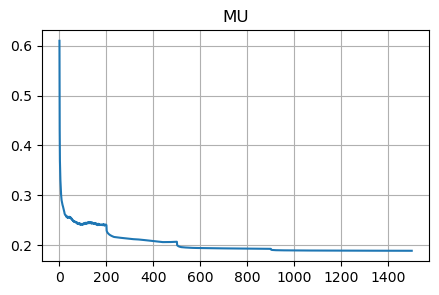

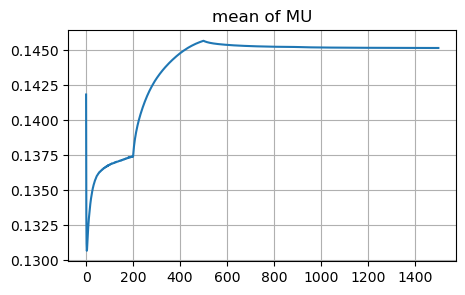

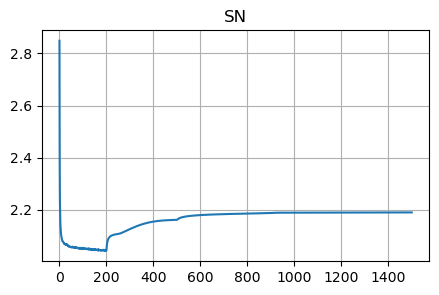

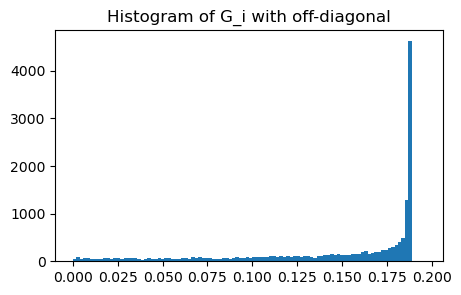

In [5]:
m = 32
n = 128
lr = 50

low_coherent_matrix, MU_all , MU_mean_all ,SN_all = execute(m,n , p = 1e1 ,p_s = 5 ,l_r = lr ,l_r_s = 0.1 , c = 0,
                                                            num_iters = [200 , 300 , 400 , 600],tight_frame = False ,
                                                            plot = True )

# Fixed method (LSEAp_Fixed)

Welch MU : 0.153695   lowwer SN : 2.0

 First MU : 0.609887 First MU_mean : 0.141836   First SN : 2.848666

 last MU : 0.202864 last MU_mean : 0.144072   last SN : 2.19982

 at minimum of Mu    Mu: 0.202864   MU_mean : 0.144072   SN : 2.19982

  total Time (s):  1.591    Time per iteration (ms):  0.106 



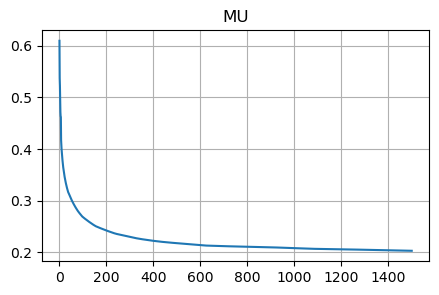

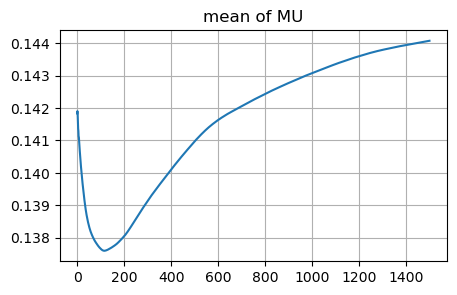

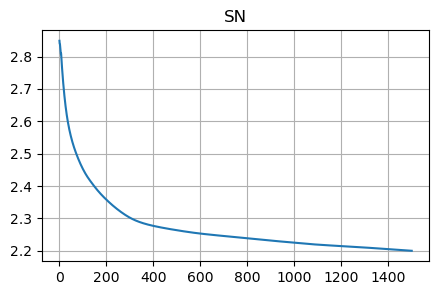

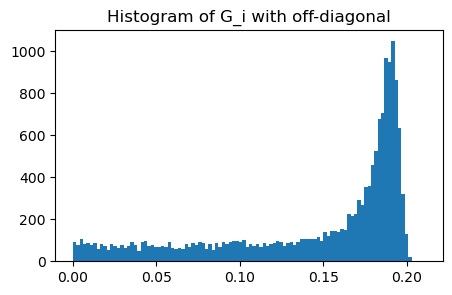

In [6]:
m = 32
n = 128
lr = 0.8

low_coherent_matrix, MU_all , MU_mean_all ,SN_all = execute(m,n , p = 1e2 ,p_s = 5 ,l_r = lr ,l_r_s = 0.1 , c = 0,
                                                            num_iters = [1500],tight_frame = False ,
                                                            plot = True )

# Double loss method (LSEAp_SN)

Welch MU : 0.153695   lowwer SN : 2.0

 First MU : 0.609887 First MU_mean : 0.141836   First SN : 2.848666

 last MU : 0.208838 last MU_mean : 0.140158   last SN : 2.07949

 at minimum of Mu    Mu: 0.208838   MU_mean : 0.140158   SN : 2.07949

  total Time (s):  1.696    Time per iteration (ms):  0.113 



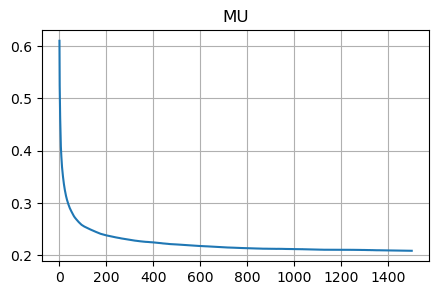

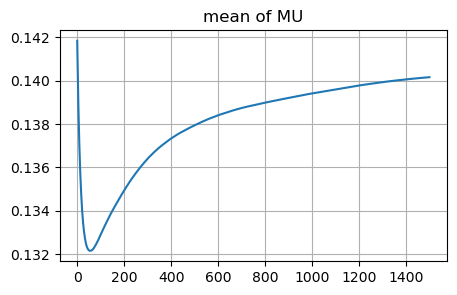

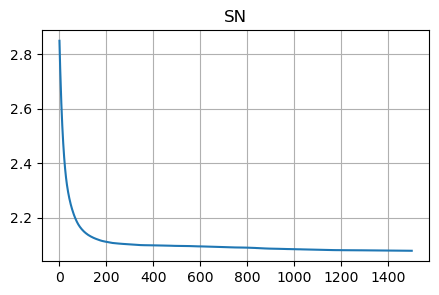

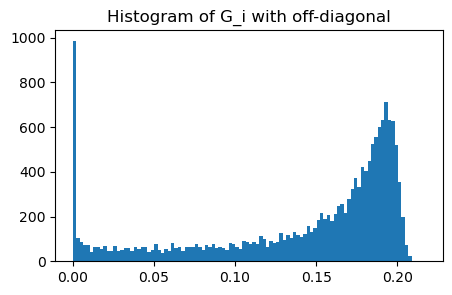

In [7]:
m = 32
n = 128
lr = 0.4

low_coherent_matrix, MU_all , MU_mean_all ,SN_all = execute(m,n , p = 1e2 ,p_s = 5 ,l_r = lr ,l_r_s = 0.1 , c = 8,
                                                            num_iters = [1500],tight_frame = False ,
                                                            plot = True )